# Modelo predictivo de factores relacionados para el reingreso de pacientes al area hospitalaria
- La finalidad del proyecto es conocer los factores que impactan directamente a la probabilidad de que un paciente reingrese al area hospitalaria una vez que este mismo fue dado de alta.

**Integrantes: Alejandro Silva, Fabiola Fragoso, Danny Palacios, Alejandro Giraldo**

### Modelo supervisado
- Clasificacion binaria: XGBOOST
- Variable Dependiente: readmitted (Readmision)

##  Entendimiento del Problema (Negocio)

Justificación: 
- La diabetes es una de las enfermedades más caras en EE.UU.
- El manejo en hospitales es inconsistente.
- Mejor control → menos infecciones, menos crisis, menos readmisión.
- Impacto directo en morbilidad, mortalidad y costos.

Este estudio analizó casi 70,000 hospitalizaciones de pacientes con diabetes en EE.UU. para entender si medir HbA1c (un indicador clave de control glucémico) reduce las readmisiones.

La diabetes es una de las enfermedades más costosas. Los hospitales pierden dinero y calidad cuando los pacientes diabéticos regresan por mala gestión del control glucémico durante su hospitalización.

Muchos hospitales NO miden HbA1c, lo que lleva a: control deficiente, tratamiento arbitrario, más complicaciones, mayores costos por readmisión,peor calidad percibida.

-  Objetivo del hospital / organización. Determinar si medir HbA1c puede:
    - Mejorar el manejo de la diabetes, reducir readmisiones a 30 días, disminuir costos, estandarizar protocolos, mejorar seguridad del paciente.

### Valor de negocio

Si un hospital implementa medición rutinaria de HbA1c: Reduce penalidades por readmisiones (Medicare), mejora la calidad y la acreditación, protege ingresos, mejora resultados clínicos.

Este estudio sirve como “evidencia base” para justificar cambios institucionales.

Preguntas clave:

- ¿Qué factores predicen la readmisión temprana?
- ¿La medición de HbA1c reduce el riesgo de readmisión?
- ¿Qué grupos de pacientes presentan mayor riesgo?

Éxito:

- Modelo con capacidad predictiva aceptable.
- Identificación de variables clave que soporten decisiones clínicas.
- Propuestas para mejorar protocolos hospitalarios.

### Carga de datos.
- Los datos fueron obtenidos de la famosa pagina Kaggle, y se pueden encontrar en el siguiente link: https://www.kaggle.com/datasets/brandao/diabetes

In [2]:
# Para mejor manejo y limpieza de codigo importare todas las librerias que se utilizaran al principio del notebook.

# Importo las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
#from sklearn.metrics import plot_roc_curve
import numpy as np


# Importaciones necesarias para Optuna
import optuna
import xgboost as xgb
# Importamos la visualización específica de Plotly
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice

# Configuración visual estilo para sns.
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Carga de datos

df = pd.read_csv('../data/raw/diabetic_data.csv', na_values="?")
# Vista previa de las primeras 5 lineas del data set.
df.head()

C:\Users\asjer\AppData\Local\Temp\ipykernel_18416\2735104178.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/diabetic_data.csv', na_values="?")


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Limpieza de datos.
- Decisiones de limpieza basadas en la calidad del dato:
- **Drop:** `payer_code`, `medical_specialty` (demasiados nulos).
- **Filtro:** Eliminamos encuentros que terminaron en fallecimiento (ya que no pueden reingresar).
- **Target:** Binarizamos `readmitted`: 1 si es `<30`, 0 en otro caso.

In [4]:
# Eliminar columnas identificatorias
cols_to_drop = ['payer_code', 'encounter_id', 'patient_nbr']
df = df.drop(columns=cols_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    3197 non-null    object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   medical_specialty         51817 non-null   object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  numb

In [5]:
# Eliminar filas con nulos en variables críticas (son pocos)
df = df.dropna(subset=['race', 'gender', 'diag_1'])

Se eliminan los registros de pacientes fallecidos o en hospicio (discharge_disposition_id 11, 13, 14, 19, 20, 21), ya que es imposible que reingresen y sesgarían el modelo hacia "No Readmitted"

In [6]:
# Eliminar pacientes fallecidos o hospicio (IDs 11, 13, 14, 19, 20, 21)
# Esto es crucial para no sesgar el modelo de "readmisión"
dead_hospice_ids = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(dead_hospice_ids)]

In [7]:
# Filtrar género inválido
df = df[df['gender'] != 'Unknown/Invalid']

**Visualizacion inicial de la variable objetivo**

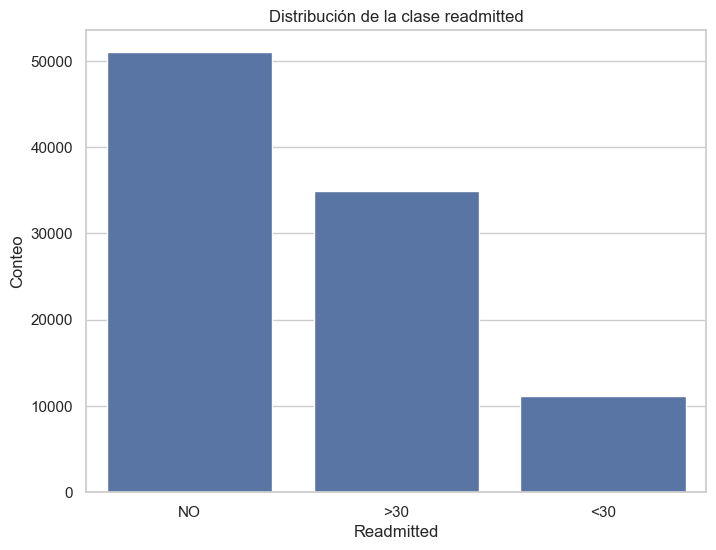

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(x='readmitted', data=df) # Assuming 'df' is your DataFrame
plt.title('Distribución de la clase readmitted')
plt.xlabel('Readmitted')
plt.ylabel('Conteo')
plt.show()

C:\Users\asjer\AppData\Local\Temp\ipykernel_18416\2457636382.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


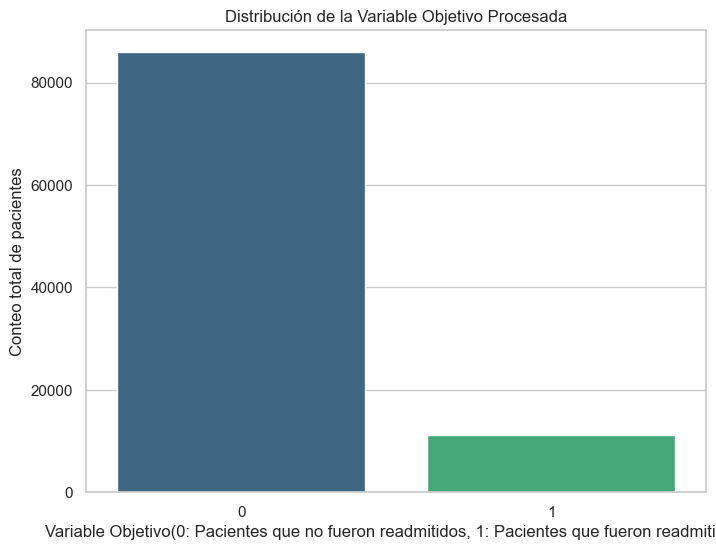

In [9]:
# Definir Target: Readmitted < 30 days (Clase Positiva = 1)
# Esta es la clase minoritaria y la más importante para la salud
df['target'] = (df['readmitted'] == '<30').astype(int)
    

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Distribución de la Variable Objetivo Procesada')
plt.xlabel('Variable Objetivo(0: Pacientes que no fueron readmitidos, 1: Pacientes que fueron readmitidos)')
plt.ylabel('Conteo total de pacientes')
plt.show()


**Interpretación de resultados**
- Se observa un desvalance de clases ya que previamente se ajusto para tratar de predecir una readmision temprana.
- Se agruparon los pacientes que fueron readmitidos y aquellos que fueron readmitidos 30 dias despues como (0)
- Se agrupo solo aquellos que fueron readmitidos en menos de 30 dias como (1)

In [10]:
# Drop columna original del target y secundarias
df = df.drop(columns=['readmitted'])

# Visualizar data set
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,target
0,Caucasian,Female,[0-10),NaN,6,25,1,1,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,11,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,44,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,51,...,No,Steady,No,No,No,No,No,Ch,Yes,0


### Ingeniería de Características (ICD-9)
- La clave en este dataset no es usar los códigos de diagnóstico crudos (hay cientos), sino agruparlos en 9 categorías clínicas (Circulatorio, Respiratorio, Diabetes, etc.) siguiendo el estándar médico. 
- Esto reduce drásticamente la dimensionalidad y mejora la generalización.

In [11]:
# Función auxiliar para agrupar códigos ICD-9
def map_icd9_code(code):
    if pd.isna(code): return 'Other'
    if str(code).startswith(('V', 'E')): return 'Other'
    try:
        n = float(code)
    except:
        return 'Other'
    
    if 390 <= n <= 459 or n == 785: return 'Circulatory'
    if 460 <= n <= 519 or n == 786: return 'Respiratory'
    if 520 <= n <= 579 or n == 787: return 'Digestive'
    if 250 <= n < 251: return 'Diabetes'
    if 800 <= n <= 999: return 'Injury'
    if 710 <= n <= 739: return 'Musculoskeletal'
    if 580 <= n <= 629 or n == 788: return 'Genitourinary'
    if 140 <= n <= 239: return 'Neoplasms'
    return 'Other'

# Aplicar agrupación de ICD9 a diag_1 (Diagnóstico primario es el más predictivo)
df['primary_diag_group'] = df['diag_1'].apply(map_icd9_code)

### Ingenieria de caracteristicas Discharge_disposition_id usando estandar HL7

In [12]:
df['discharge_disposition_id'].value_counts()

discharge_disposition_id
1     58761
3     13611
6     12694
18     3672
2      2060
22     1981
5      1142
25      972
4       765
7       610
23      406
28      138
8       107
15       63
24       48
9        21
17       14
16       11
10        6
27        5
12        3
Name: count, dtype: int64

C:\Users\asjer\AppData\Local\Temp\ipykernel_18416\539647494.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discharge_disposition_id_counts.index, y=discharge_disposition_id_counts.values, palette='viridis')


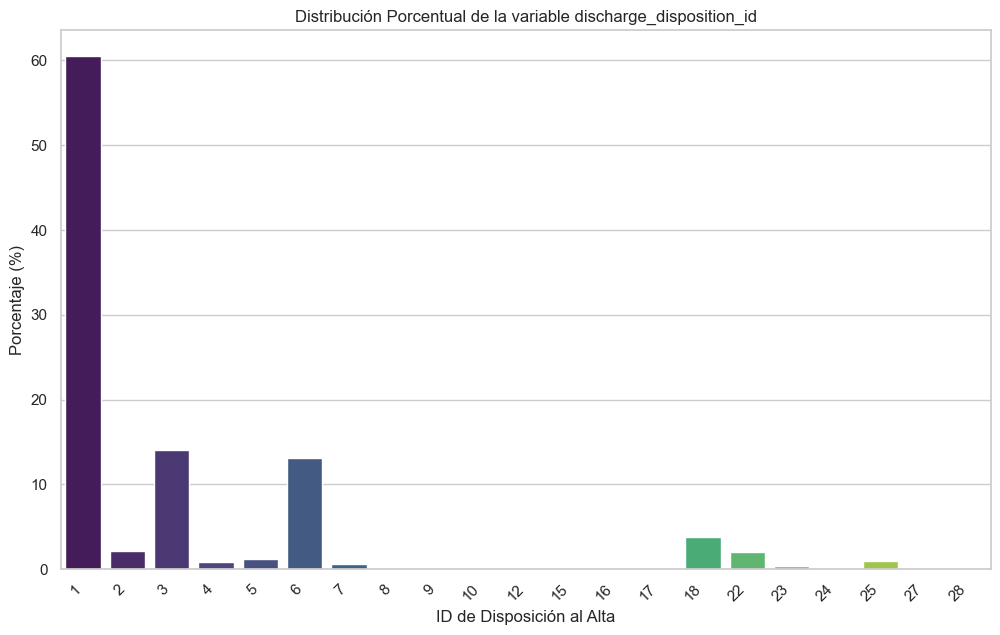

In [13]:
# Visuzalicacion de la categoria discharge_disposition_id

discharge_disposition_id_counts = df['discharge_disposition_id'].value_counts(normalize=True) * 100
plt.figure(figsize=(12, 7))
sns.barplot(x=discharge_disposition_id_counts.index, y=discharge_disposition_id_counts.values, palette='viridis')
plt.title('Distribución Porcentual de la variable discharge_disposition_id')
plt.xlabel('ID de Disposición al Alta')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45, ha='right')
plt.show()

Se agrupa la categoria de alta en el formato clinico HL7.
- Se pueden observar la siguiente distribucion de altas:
- - 1: Alta a domicilio con el mayor porcentaje aporximadamente el 61% del total (58,761) de observaciones.
- - 3: Alta a hospital de cuidados agudos/subagudos -- Aqui se agrupa el id 2 y 3 ya que ambas altas pertenecen al traslado a hospital de cuidados  agudos/subagudos respectivamente. el cual corresponde a un total de (15,711) obersvaciones.
- - 6: Alta a hospital psiquiatrico con untotal de 12694 observaciones.
El resto de id de alta se agrupan en la categoria "Otros"

In [14]:
def map_discharge_id(discharge_id):
    """
    Mapea el ID de alta a una categoría descriptiva usando el estandar HL7
    """
    if discharge_id == 1:
        return 'Alta a domicilio'
    elif discharge_id == 2 or discharge_id == 3:
        return 'Traslado a un hospital de cuidados segundo y tercer nivel'
    elif discharge_id == 6:
        return 'Traslado a un hosptial psiquiatrico'
    else:
        return 'Otros'
df['discharge_category'] = df['discharge_disposition_id'].apply(map_discharge_id)
df.drop(columns=['discharge_disposition_id'], inplace=True)


C:\Users\asjer\AppData\Local\Temp\ipykernel_18416\1823102114.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df['discharge_category'], palette='viridis')


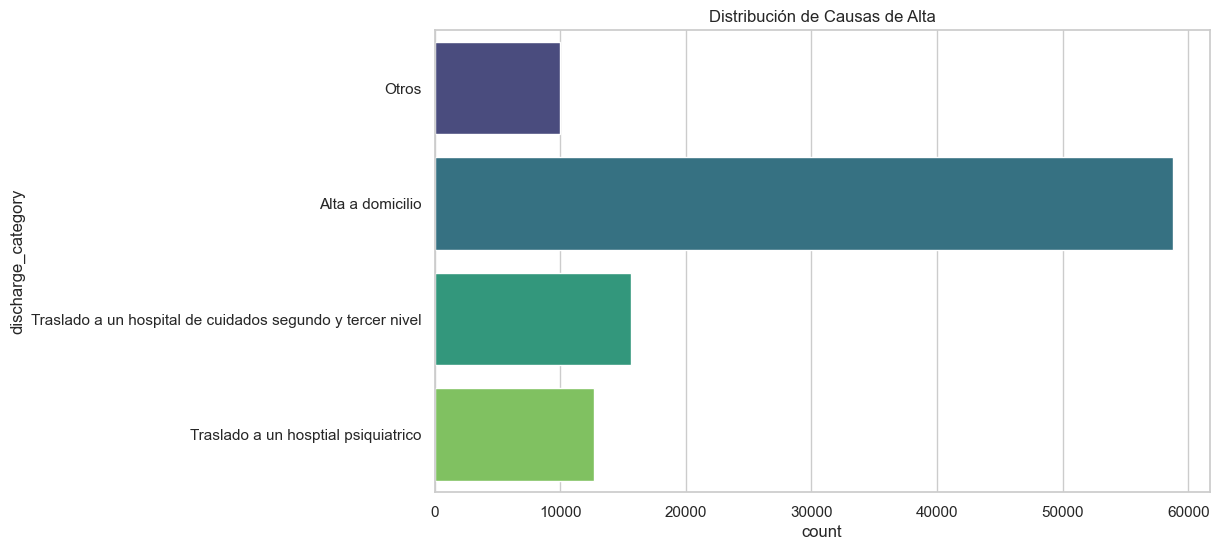

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df['discharge_category'], palette='viridis')
plt.title('Distribución de Causas de Alta')
plt.show()


El grafico muestra la distribucion de las id de altas, donde se puede observar que la mayoria de los pacientes fueron dados de alta a su domicilio, agrupar en 3 categorias diminuye considerablemnte el ruido para entrenar el modelo, de esta manera se tiene un orden mas preciso para clasificar las id de altas que tuvieron mayor valor.

### Preparacion del Pipeline
- Genero un flujo para los datos en un pipeline, donde se llevan a cabo las siguientes transformaciones:
    - Separar la variable objetivo (target)
    - Identificar variables categóricas y numéricas
    - Aplicar StandardScaler a las variables numéricas
    - Aplicar OneHotEncoder a las variables categóricas
    - Unir las variables transformadas
    - Aplicar el modelo
- Aplico scale_pos_weight para balancear la clase mayoritaria, de esta manera el modelo prestara mas atencion a la clase minoritaria que es la que nos interesa que prediga correctamente ya que son los pacientes que van a reingresar y asi reducir el margen de error.

In [16]:
# Separar Features y Target
X = df.drop(columns=['target', 'diag_1', 'diag_2', 'diag_3']) # Usamos el grupo creado, dropeamos los crudos
y = df['target']
# Divodo la data en train y test asegurandome de configurar stratify a la data target (y).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identificar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocesadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Mediana es robusta a outliers
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False para visualización fácil si se requiere
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Calculamos el ratio para balancear clases (Negativos / Positivos)
# Esto ayuda drásticamente al Recall
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# Pipeline Final con XGBoost
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        scale_pos_weight=scale_pos_weight, # CLAVE para Recall
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

Aplico validacion cruzada para obtener mejor rendimiento y evitar el sobre ajuste del modelo.

In [17]:
# Cross Validation Stratified para mantener proporción de clases
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Obtenemos predicciones "limpias" usando CV
y_pred_cv = cross_val_predict(model_pipeline, X, y, cv=cv)
y_proba_cv = cross_val_predict(model_pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

# Métricas
print("\nReporte de Clasificación (Validación Cruzada)")
print(classification_report(y, y_pred_cv))

roc_auc = roc_auc_score(y, y_proba_cv)
print(f"ROC-AUC Score Promedio: {roc_auc:.4f}")

c:\Users\asjer\OneDrive\Documentos\4GeeksAcademy\modelo-predictivo-reingreso-pacientes\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:11:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\asjer\OneDrive\Documentos\4GeeksAcademy\modelo-predictivo-reingreso-pacientes\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:11:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\asjer\OneDrive\Documentos\4GeeksAcademy\modelo-predictivo-reingreso-pacientes\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:11:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\asjer\OneDrive\D


Reporte de Clasificación (Validación Cruzada)
              precision    recall  f1-score   support

           0       0.92      0.64      0.75     85969
           1       0.17      0.59      0.27     11121

    accuracy                           0.63     97090
   macro avg       0.55      0.61      0.51     97090
weighted avg       0.84      0.63      0.70     97090

ROC-AUC Score Promedio: 0.6609


### Matriz de Confusión: Análisis de Errores Críticos
Esta visualización separa los aciertos de los errores mediante el uso de color:
- **Diagonal Azul (Aciertos):** El modelo predijo correctamente.
- **Diagonal Roja (Errores):** El modelo falló.
    - **ATENCIÓN AL CUADRANTE INFERIOR IZQUIERDO (FN):** Representa los casos de reingreso que no detectamos. Este es el punto ciego del modelo que debemos vigilar.

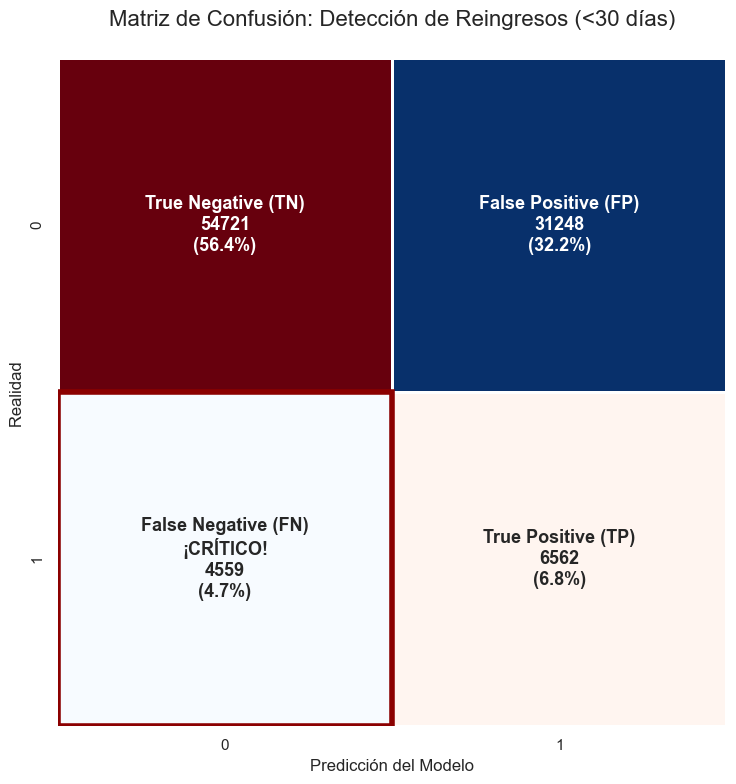

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_enhanced_confusion_matrix(y_true, y_pred):
    # 1. Calcular matriz y variables
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcular porcentajes
    cm_perc = cm / cm.sum()
    
    # 2. Definir etiquetas ricas (Texto + Datos)
    labels = np.array([
        [f"True Negative (TN)\n{tn}\n({cm_perc[0,0]:.1%})", f"False Positive (FP)\n{fp}\n({cm_perc[0,1]:.1%})"],
        [f"False Negative (FN)\n¡CRÍTICO!\n{fn}\n({cm_perc[1,0]:.1%})", f"True Positive (TP)\n{tp}\n({cm_perc[1,1]:.1%})"]
    ])
    
    # 3. Configurar el gráfico
    plt.figure(figsize=(10, 8))
    
    # DOBLE HEATMAP
    # Máscara para ocultar la diagonal (para pintar los errores de Rojo)
    mask_good = np.array([[False, True], [True, False]]) 
    # Máscara para ocultar los errores (para pintar los aciertos de Azul)
    mask_bad = np.array([[True, False], [False, True]])
    
    # Capa 1: Aciertos (Azul) - Diagonal principal
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', mask=mask_bad, 
                cbar=False, square=True, annot_kws={'size': 13, 'weight': 'bold'},
                linewidths=2, linecolor='white')
    
    # Capa 2: Errores (Rojo) - Diagonal inversa
    # Al usar 'Reds', el FN (y el FP) se pintarán de rojo.
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds', mask=mask_good, 
                cbar=False, square=True, annot_kws={'size': 13, 'weight': 'bold'},
                linewidths=2, linecolor='white')
    
    # Ajustes finales
    plt.title('Matriz de Confusión: Detección de Reingresos (<30 días)\n', fontsize=16)
    plt.xlabel('Predicción del Modelo', fontsize=12)
    plt.ylabel('Realidad ', fontsize=12)
    
    # Dibujamos un rectángulo rojo grueso alrededor de la celda del FN (posición 1,0)
    from matplotlib.patches import Rectangle
    ax = plt.gca()
    rect = Rectangle((0, 1), 1, 1, fill=False, edgecolor='darkred', lw=4)
    ax.add_patch(rect)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/confusion_matrix_enhanced.png') # Guardo con nuevo nombre
    plt.show()
plot_enhanced_confusion_matrix(y, y_pred_cv)

**Interpretacion**
- A diferencia de otros problemas la interpretacion e importancia puede variar, aqui estamos tratando con un problema de clasificacion binaria en donde la importancia tendra impacto directo a la salud del paciente.
- Nos centraremos en los falsos negativos, el modelo tiene un margen de error del 4.8% lo que resultaria como aquellos pacientes que detecta como sanos y reingresaran en 30 dias.

c:\Users\asjer\OneDrive\Documentos\4GeeksAcademy\modelo-predictivo-reingreso-pacientes\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:11:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\asjer\AppData\Local\Temp\ipykernel_18416\2037624328.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')


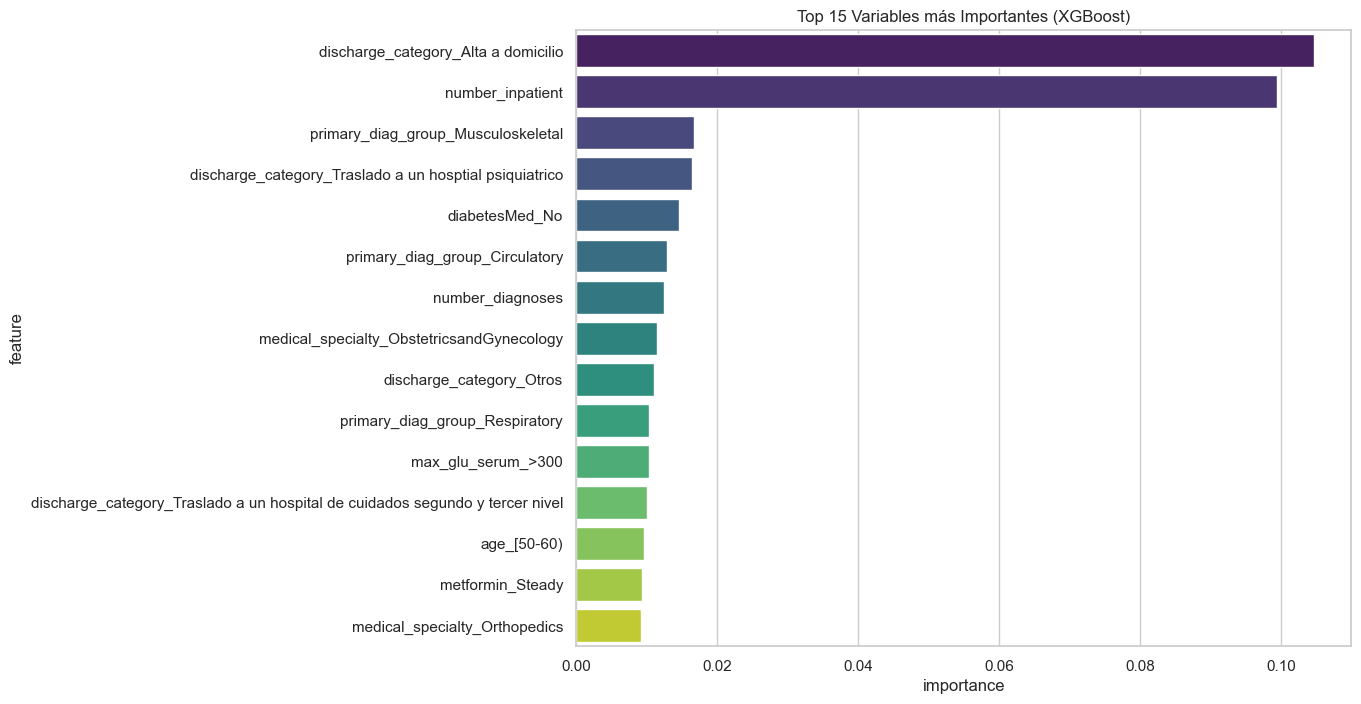

In [19]:
# Importancia de Variables (Extraída del modelo entrenado en toda la data)
model_pipeline.fit(X, y) # Entrenamos en todo para extraer feature importance
feature_names = (num_cols + 
                 list(model_pipeline.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(cat_cols)))

importances = model_pipeline.named_steps['classifier'].feature_importances_
# Crear DF para plotear
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')
plt.title('Top 15 Variables más Importantes (XGBoost)')
plt.savefig('../reports/figures/feature_importance.png')
plt.show()

**Interpretación**
- El grafico muestra la importancia de las caracteristicas de nuestros datos que el modelo interpreto como mas relevantes para predecir el resultado.
- Van ordenado en forma descendente.
### Podemos destacar las dos principales variables que tienen mas relevancia:
- number_inpatient: numero de hospitalizaciones previas.
- discharge_disposition_id: destino del paciente al ser dado de alta.
### El resto de variables tienen un nivel de importancia similar pero igual siguen siendo relevantes.
- primary_diag_group_Musculoskeletal: Grupo de diagnostico primario especificamente uno asociado al sistema musculoesquelético.
- diabetesMed: medicación para diabetes.
- primary_diag_group_Circulatory: Grupo de diagnostico primario especificamente uno asociado al sistema Circulatorio.
- number_of_diagnoses: numero total de diagnósticos registrados.
- glimepiride: medicación para diabetes, especificamente glimepiride.
- metformin_steady: medicación para diabetes, especificamente metformina.
- insulin_No: medicación para diabetes, especificamente insulina.
- A1Cresult_7: Resultado en pruebas A1C.
- primary_diag_group_Diabetes: Grupo de diagnostico primario especificamente uno asociado al sistema Diabetes.
- race_Asian: raza del paciente, especificamente Asiatica. 
- primary_diag_group_Respiratory: Grupo de diagnostico primario especificamente uno asociado al sistema Respiratorio.
- age_(50-60): Edad del paciente (punto medio del rango decenal).
- pioglitazone_Up: medicación para diabetes, especificamente pioglitazone.

### Optimizacion del modelo
- Para llevar este modelo al nivel de producción, abandonamos la búsqueda por fuerza bruta (GridSearchCV) y pasamos a Optimización Bayesiana con Optuna.
- A diferencia de probar combinaciones al azar, Optuna aprende de las pruebas anteriores para encontrar los mejores hiperparámetros más rápido y de manera inteligente.

- Métrica Objetivo: Maximizamos ROC-AUC dentro de la validación cruzada. Esto garantiza que el modelo distinga bien entre clases sin depender del umbral de decisión.

- Espacio de Búsqueda: No solo afinamos n_estimators o learning_rate. Incluímos scale_pos_weight (crítico para el desbalance de clases en salud) y gamma (para controlar el sobreajuste/regularización).
- Utilizo otro filtro para equilibrar el desbalance de clases utilizando StratifiedKFold. dentro de la funcion de optuna esto añade otra capa de robustez al modelo, ya que en cada fold (un total de 5) se está equilibrando el desbalance de clases dentro del pipeline, asi se resuelve el problema de la fuga de datos y el sobre ajuste.

In [20]:
import optuna

def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10), # Clave para desbalance
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    
    # Pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(**params))
    ])
    
    # Validación Cruzada dentro de la optimización (Robustez)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    return scores.mean()

# Ejecuto el estudio
print("Iniciando optimización con Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True) 

print("Mejores parámetros encontrados:")
print(study.best_params)

[I 2025-12-12 12:11:50,957] A new study created in memory with name: no-name-cf7419d2-bf15-4611-b264-0df549b25392


Iniciando optimización con Optuna...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-12 12:12:02,634] Trial 0 finished with value: 0.6372325683013393 and parameters: {'n_estimators': 324, 'max_depth': 7, 'learning_rate': 0.1132235686664181, 'subsample': 0.8928894763128439, 'colsample_bytree': 0.9449061168514248, 'gamma': 1.8693709755562882, 'scale_pos_weight': 9.49301499301432}. Best is trial 0 with value: 0.6372325683013393.
[I 2025-12-12 12:12:14,742] Trial 1 finished with value: 0.6497597515648172 and parameters: {'n_estimators': 370, 'max_depth': 8, 'learning_rate': 0.05003450914501392, 'subsample': 0.8794431015545898, 'colsample_bytree': 0.9353954132323778, 'gamma': 0.9839868213166925, 'scale_pos_weight': 7.351164335367461}. Best is trial 1 with value: 0.6497597515648172.
[I 2025-12-12 12:12:21,500] Trial 2 finished with value: 0.6663467889250717 and parameters: {'n_estimators': 158, 'max_depth': 6, 'learning_rate': 0.07003724094885311, 'subsample': 0.9840257170494464, 'colsample_bytree': 0.8386989116274514, 'gamma': 0.46275070547989794, 'scale_pos_weig

### Graficos optuna.
- Se generan 3 graficos cada una con un objetivo propio:
- Hisotria de optimizacion: Revela como evoluciona el valor objetivo a lo largo de las iteraciones.
- Importancia de los hiperparametros: Muestra la relevancia de cada hiperparametro en la optimizacion.
- Slice plot: Muestra donde se concentran los mejores puntos para cada párametro individual.

In [21]:
# Historia de Optimización
# Muestra cómo el AUC mejora con cada trial.
fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historia de Optimización (Progreso del AUC)", width=900, height=500)
fig1.write_image('../reports/figures/optimization_history.png')

fig1.show()

# Importancia de Hiperparámetros
# Te dirá qué variable afecta más. Probablemente 'scale_pos_weight' o 'learning_rate'.
fig2 = plot_param_importances(study)
fig2.update_layout(title="¿Qué hiperparámetros importan más?", width=900, height=500)
fig2.write_image('../reports/figures/params_importance.png')
fig2.show()

# Slice Plot
# Muestra dónde se concentran los mejores puntos para cada parámetro individual.
fig3 = plot_slice(study)
fig3.update_layout(title="Relación Individual de Parámetros vs AUC", width=900, height=500)
fig3.write_image('../reports/figures/slice.png')
fig3.show()

### Entrenamiento final y graficos.
- Una vez encontrado los mejores hiperparametros, se procede a entrenar el modelo final.

In [22]:
# Entreno el mejor modelo con todos los datos de train
best_params = study.best_params
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params, random_state=42, eval_metric='logloss'))
])
best_model.fit(X_train, y_train)

# Predicciones
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

### Evaluando el Modelo optimizado.

AUC: 0.6588660021732526
Recall: 0.10251798561151079


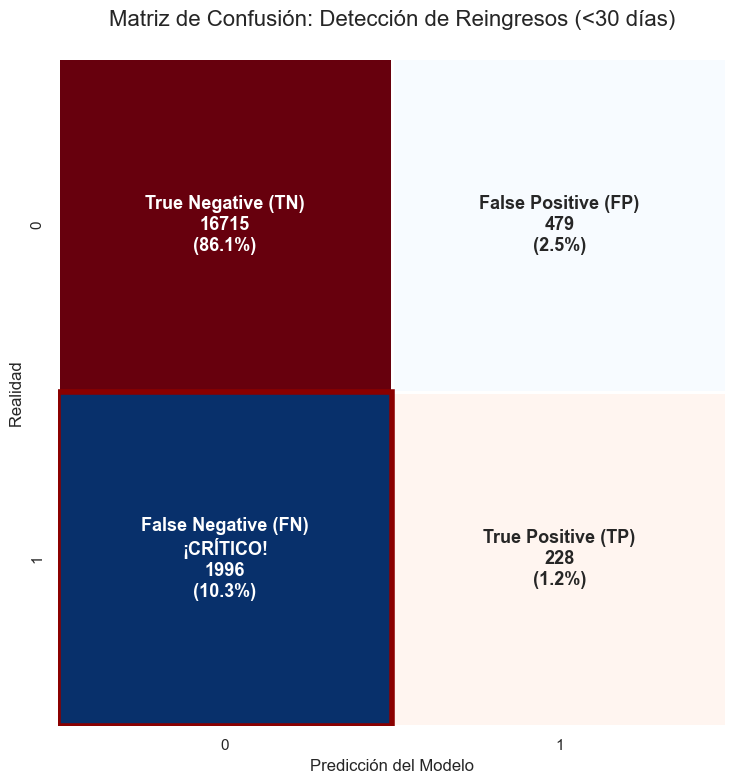

In [30]:
from sklearn.metrics import roc_auc_score, recall_score
print(f"AUC: {roc_auc_score(y_test, y_proba)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_curve

plot_enhanced_confusion_matrix(y_test, y_pred)

# grafico auc_roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
fig_roc = go.Figure(data=[
    go.Scatter(x=fpr, y=tpr, mode='lines', name='Curva ROC (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba))),
    go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Clasificador Aleatorio')
])
fig_roc.update_layout(
    title='Curva ROC',
    xaxis_title='Tasa de Falsos Positivos (FPR)',
    yaxis_title='Tasa de Verdaderos Positivos (TPR)',
    template='plotly_white'
)
fig_roc.write_image('../reports/figures/roc_curve_optuna.png')
fig_roc.show()


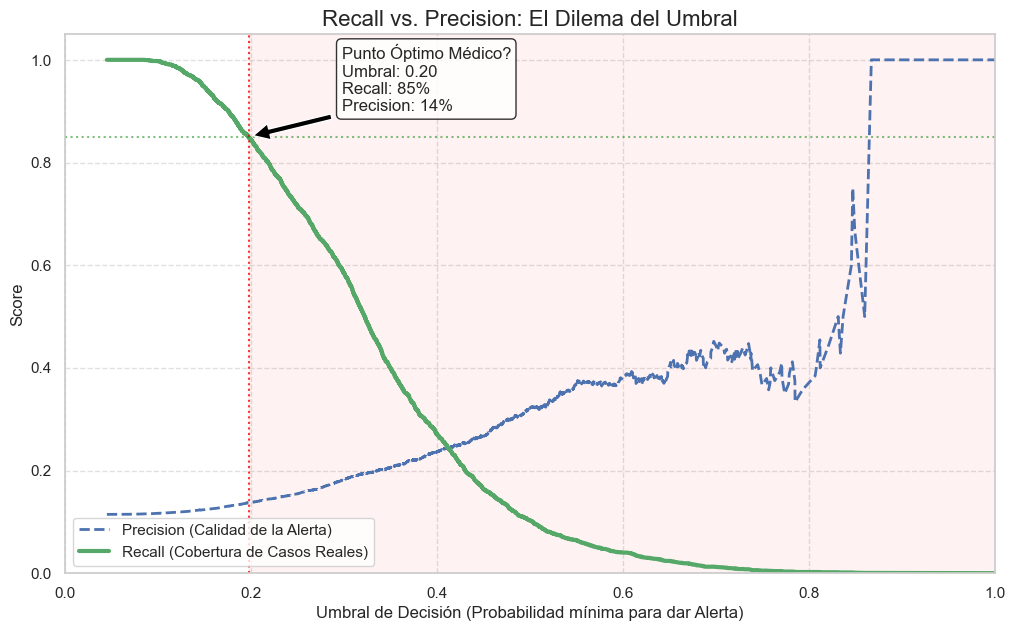

In [31]:

def plot_recall_threshold_tradeoff(y_true, y_probas):
    # Obtenemos las curvas de precisión y recall para todos los umbrales
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probas)
    
    # Ajuste de dimensiones porque 'thresholds' tiene un elemento menos
    thresholds_plot = np.append(thresholds, 1)
    
    plt.figure(figsize=(12, 7))
    
    # Ploteamos las para hacer una comparativa
    plt.plot(thresholds_plot, precisions, 'b--', label='Precision (Calidad de la Alerta)', linewidth=2)
    plt.plot(thresholds_plot, recalls, 'g-', label='Recall (Cobertura de Casos Reales)', linewidth=3)
    
    # Decoración para interpretación fácil
    plt.title('Recall vs. Precision: El Dilema del Umbral', fontsize=16)
    plt.xlabel('Umbral de Decisión (Probabilidad mínima para dar Alerta)', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend(loc='lower left', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Buscamos el umbral más cercano donde Recall aprox 0.85
    target_recall = 0.85
    idx = np.argmin(np.abs(recalls - target_recall))
    ref_thresh = thresholds_plot[idx]
    ref_prec = precisions[idx]
    
    # Dibujamos líneas guía para ese punto estratégico
    plt.axvline(ref_thresh, color='red', linestyle=':', alpha=0.8)
    plt.axhline(target_recall, color='green', linestyle=':', alpha=0.5)
    
    # Anotación explicativa "Senior"
    plt.annotate(f'Punto Óptimo Médico?\nUmbral: {ref_thresh:.2f}\nRecall: {target_recall:.0%}\nPrecision: {ref_prec:.0%}',
                 xy=(ref_thresh, target_recall), 
                 xytext=(ref_thresh + 0.1, target_recall + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    # Zona de Peligro (Donde perdemos demasiados pacientes)
    plt.axvspan(ref_thresh, 1.0, color='red', alpha=0.05, label='Zona de Alto Riesgo (Bajo Recall)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.savefig('../reports/figures/recall_threshold_tradeoff.png')
    plt.show()

probs_to_plot = y_proba
        
plot_recall_threshold_tradeoff(y_test, probs_to_plot) 


**Interpretación de datos**
- El grafico muestra una curva decendente donde se busca encontrar el punto de umbral optimo para aumentar el recall del modelo, se toma en cuenta cuando la curva cae abruptamente, ese es el punto de inflexión.
- En este caso el umbral es de .14 oh 14%, el cual usaremos para diminuir la tasa de falsos negattivos.

--- Evaluacion del umbral optimizado (Umbral: 0.2) ---
              precision    recall  f1-score   support

           0       0.94      0.32      0.47     17194
           1       0.14      0.84      0.24      2224

    accuracy                           0.38     19418
   macro avg       0.54      0.58      0.36     19418
weighted avg       0.85      0.38      0.45     19418



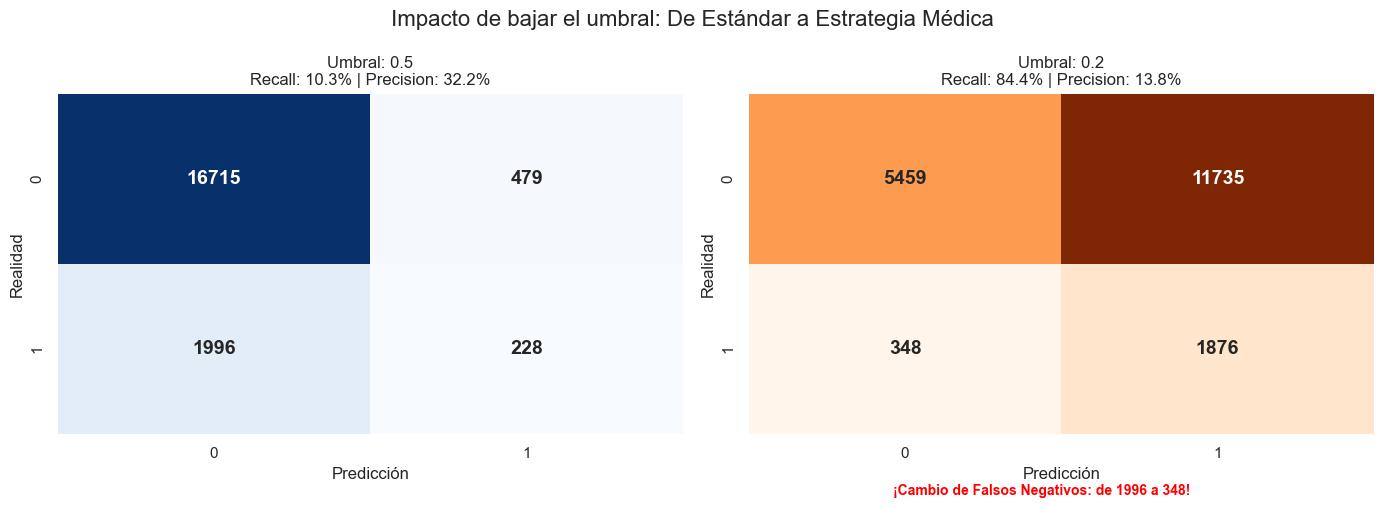

Gracias a bajar el umbral, se detectarían 1650 pacientes extra que realmente reingresaron.
Estos pacientes habrían sido ignorados con el umbral estándar.
       Probabilidad_Modelo  Prediccion_Final  Realidad
25244                0.469                 1         1
63079                0.438                 1         1
85970                0.232                 1         1
67754                0.403                 1         1
84558                0.236                 1         1


In [33]:
# Obtener probabilidades del Test Set
y_proba_test = best_model.predict_proba(X_test)[:, 1]

# Aplicar el umbral optimizado (.20)
THRESHOLD = 0.20
y_pred_custom = (y_proba_test >= THRESHOLD).astype(int)

# Comparativa: Umbral Default (0.5) vs Umbral Médico (0.20)
print(f"--- Evaluacion del umbral optimizado (Umbral: {THRESHOLD}) ---")
print(classification_report(y_test, y_pred_custom))

# Visualizacion comparativa del impacto del umbral
def compare_thresholds(y_true, probs, thresh_list=[0.5, 0.20]):
    plt.figure(figsize=(14, 5))
    
    for i, thresh in enumerate(thresh_list):
        plt.subplot(1, 2, i+1)
        preds = (probs >= thresh).astype(int)
        cm = confusion_matrix(y_true, preds)
        tn, fp, fn, tp = cm.ravel()
        
        # Mapa de calor
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' if i==0 else 'Oranges', cbar=False,
                    annot_kws={'size': 14, 'weight': 'bold'})
        
        plt.title(f'Umbral: {thresh}\nRecall: {tp/(tp+fn):.1%} | Precision: {tp/(tp+fp):.1%}')
        plt.xlabel('Predicción')
        plt.ylabel('Realidad')
        
        # Anotación explicativa debajo
        if i == 1: # En el umbral optimizado
            plt.figtext(0.75, 0.01, f"¡Cambio de Falsos Negativos: de {confusion_matrix(y_true, (probs>=0.5).astype(int))[1,0]} a {fn}!", 
                        ha="center", fontsize=10, color="red", weight="bold")

    plt.suptitle("Impacto de bajar el umbral: De Estándar a Estrategia Médica", fontsize=16)
    plt.tight_layout()
    plt.savefig('../reports/figures/threshold_comparison.png')
    plt.show()

compare_thresholds(y_test, y_proba_test, thresh_list=[0.5, 0.20]) # 0.5 umbral estandar, .12 umbral optimizado grado clinico.

# Resultados finales: 
results_df = pd.DataFrame({
    'Probabilidad_Modelo': y_proba_test.round(3),
    'Prediccion_Final': y_pred_custom,
    'Realidad': y_test
})

# Filtramos solo los que son "Rescatados" por tu nuevo umbral
rescued_patients = results_df[
    (results_df['Probabilidad_Modelo'] >= 0.20) & 
    (results_df['Probabilidad_Modelo'] < 0.5) & 
    (results_df['Realidad'] == 1)
]

print(f"Gracias a bajar el umbral, se detectarían {len(rescued_patients)} pacientes extra que realmente reingresaron.")
print("Estos pacientes habrían sido ignorados con el umbral estándar.")
print(rescued_patients.head())

### Pensemos en un momento en la cifra de 1650 .
- En un contexto académico son solo filas en un CSV. 
- En la vida real, eso equivale a llenar un hospital entero con gente que iba a volver grave y que el modelo anterior (con umbral 0.5) hubiera mandado a casa sin revisión. 
- Eso es impacto real que es la finalidad de este proyecto, no buscamos tener el mejor AUC posible, sino que buscamos que el modelo nos ayude a prevenir reingresos y de esa manera tomar en cuenta a esos 1875 pacientes que podrian tener algun otro problema asociado oh que realmente ocupen hopsitalizacion y estaban siendo ignorados.
### El Costo Operativo 
- El hospital va a recibir muchas alertas. De esos 1650 , muchos serán falsas alarmas. Pero clínicamente, revisar a un sano es barato; dejar ir a un infartado es carísimo (y trágico).

# Guardado de modelo.
- Procederé a guardar el modelo final como .joblib para su despliegue en producción.

In [26]:
# Guardar el modelo como xgb_final_model
import joblib
joblib.dump(best_model, '../models/xgb_diabetic_risk_v1.pkl')

['../models/xgb_diabetic_risk_v1.pkl']

### Grafico shap

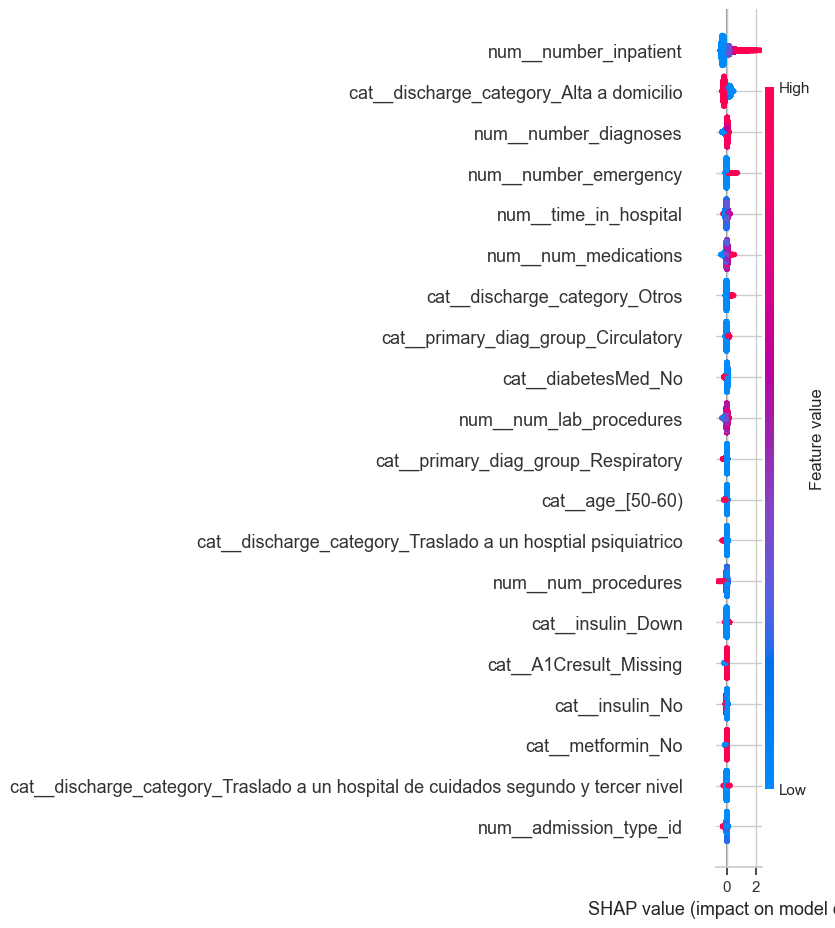

In [27]:
import shap
model_step = best_model.steps[-1][1] 
# Alternativamente, si usas scikit-learn reciente, puedes usar: best_model._final_estimator

# Transformar los datos de prueba.
preprocessor = best_model[:-1] 
X_test_transformed = preprocessor.transform(X_test)

# Crear el explainer usando el modelo extraído
explainer = shap.TreeExplainer(model_step)

# Calcular los valores SHAP usando los datos transformados
shap_values = explainer.shap_values(X_test_transformed)

if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

# Grafico utilizando shap.summary_plot funcion para evitar errores.
shap.summary_plot(shap_values, X_test_transformed)
